In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [24]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_again', 'X_train.npy'))
    labels = np.load(os.path.join('Data_again', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_again', 'X_test.npy'))
    labels = np.load(os.path.join('Data_again', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [27]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [28]:
test_labels

array([3, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 0, 1, 3, 3, 0, 1, 1, 1, 2, 2, 2,
       1, 0, 0, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 1, 1, 3, 0, 3, 0, 0, 2,
       2, 3, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 3, 0, 2, 2, 2, 1, 3, 1, 0,
       2, 0, 3, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 1, 3, 0, 3, 3, 0, 0,
       3, 1, 0, 2, 2, 0, 2, 3, 3, 0, 2, 0, 0, 0, 0, 1, 1, 1, 3, 3, 1, 1,
       3, 3, 2, 0, 0, 0, 2, 3, 3, 0, 0, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 2, 2, 2, 1, 2, 2, 3, 0, 3, 1, 0, 0, 1, 0, 1, 2, 1, 3, 0,
       0, 3, 0, 1, 2, 2, 1, 0, 1, 3, 1, 3, 1, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 2, 2, 3, 3, 1, 1, 0, 1, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 1, 3,
       2, 0, 2, 2, 1, 3, 2, 2, 3, 2, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 0, 1,
       2, 3, 2, 1, 0, 3, 3, 0, 0, 0, 0, 1, 2, 1, 1, 3, 3, 3, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 3, 0, 0, 1, 0, 3, 2, 3, 2, 0, 2, 3, 0, 0, 0, 0, 0,
       3, 1, 2, 1, 0, 0, 3, 0, 1, 0, 2, 3, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0,
       3, 0, 3, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 3,

In [29]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [30]:
train_images.shape

(2913, 256, 256, 1)

In [31]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [32]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [33]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [34]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

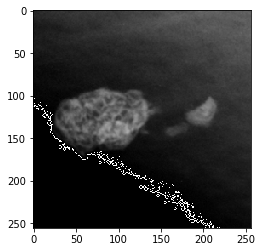

Label: [1. 0. 0. 0.]
[[[117.01171875 117.01171875 117.01171875]
  [114.30078125 114.30078125 114.30078125]
  [117.76171875 117.76171875 117.76171875]
  ...
  [130.76171875 130.76171875 130.76171875]
  [134.578125   134.578125   134.578125  ]
  [139.015625   139.015625   139.015625  ]]

 [[108.484375   108.484375   108.484375  ]
  [119.203125   119.203125   119.203125  ]
  [112.95703125 112.95703125 112.95703125]
  ...
  [132.3359375  132.3359375  132.3359375 ]
  [128.43359375 128.43359375 128.43359375]
  [136.7265625  136.7265625  136.7265625 ]]

 [[116.49609375 116.49609375 116.49609375]
  [116.78515625 116.78515625 116.78515625]
  [116.27734375 116.27734375 116.27734375]
  ...
  [128.6640625  128.6640625  128.6640625 ]
  [129.62890625 129.62890625 129.62890625]
  [136.1015625  136.1015625  136.1015625 ]]

 ...

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [199.52734375 199.52734375 199.5273437

In [35]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 789

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

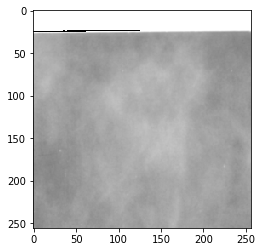

Label: [0. 0. 1. 0.]
[[[117.01171875 117.01171875 117.01171875]
  [114.30078125 114.30078125 114.30078125]
  [117.76171875 117.76171875 117.76171875]
  ...
  [130.76171875 130.76171875 130.76171875]
  [134.578125   134.578125   134.578125  ]
  [139.015625   139.015625   139.015625  ]]

 [[108.484375   108.484375   108.484375  ]
  [119.203125   119.203125   119.203125  ]
  [112.95703125 112.95703125 112.95703125]
  ...
  [132.3359375  132.3359375  132.3359375 ]
  [128.43359375 128.43359375 128.43359375]
  [136.7265625  136.7265625  136.7265625 ]]

 [[116.49609375 116.49609375 116.49609375]
  [116.78515625 116.78515625 116.78515625]
  [116.27734375 116.27734375 116.27734375]
  ...
  [128.6640625  128.6640625  128.6640625 ]
  [129.62890625 129.62890625 129.62890625]
  [136.1015625  136.1015625  136.1015625 ]]

 ...

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [199.52734375 199.52734375 199.5273437

In [36]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 5

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))

print(train_images[0])

In [37]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [15]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 48,533,572
Trainable params: 33,818,884
Non-trainable params: 14,714,688
___________________________________

In [38]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128, output = 4)

In [39]:
vgg16_fe_drop_128.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
_________________________________

In [40]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [41]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.8441 - accuracy: 0.3859
Epoch 00001: val_loss improved from inf to 1.34328, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 23s 2s/step - loss: 2.7492 - accuracy: 0.3772 - val_loss: 1.3433 - val_accuracy: 0.4089
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3851 - accuracy: 0.4487
Epoch 00002: val_loss improved from 1.34328 to 1.20763, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.3597 - accuracy: 0.4529 - val_loss: 1.2076 - val_accuracy: 0.4759
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3333 - accuracy: 0.4750
Epoch 00003: val_loss improved from 1.20763 to 1.12939, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 1.3

10/11 [==========================>...] - ETA: 1s - loss: 0.9195 - accuracy: 0.5725
Epoch 00028: val_loss improved from 0.99110 to 0.98391, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.9219 - accuracy: 0.5777 - val_loss: 0.9839 - val_accuracy: 0.5670
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9897 - accuracy: 0.5758
Epoch 00029: val_loss improved from 0.98391 to 0.98251, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.9968 - accuracy: 0.5668 - val_loss: 0.9825 - val_accuracy: 0.5498
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9706 - accuracy: 0.5471
Epoch 00030: val_loss improved from 0.98251 to 0.97790, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.9727 - accuracy: 0.5478 - val_loss: 0.9779 - val_accuracy: 0.5704
Epoch 31/300
10/11 [============

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9020 - accuracy: 0.6125
Epoch 00057: val_loss did not improve from 0.93055
11/11 [==============================] - 22s 2s/step - loss: 0.8982 - accuracy: 0.6101 - val_loss: 0.9481 - val_accuracy: 0.5756
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8962 - accuracy: 0.5802
Epoch 00058: val_loss did not improve from 0.93055
11/11 [==============================] - 20s 2s/step - loss: 0.9042 - accuracy: 0.5800 - val_loss: 0.9557 - val_accuracy: 0.6031
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8869 - accuracy: 0.6297
Epoch 00059: val_loss did not improve from 0.93055
11/11 [==============================] - 22s 2s/step - loss: 0.8949 - accuracy: 0.6236 - val_loss: 0.9732 - val_accuracy: 0.5893
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9156 - accuracy: 0.6234
Epoch 00060: val_loss did not improve from 0.93055
11/11 [==================

10/11 [==========================>...] - ETA: 1s - loss: 0.8889 - accuracy: 0.6141
Epoch 00086: val_loss improved from 0.91568 to 0.90356, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.8844 - accuracy: 0.6108 - val_loss: 0.9036 - val_accuracy: 0.6031
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8898 - accuracy: 0.6141
Epoch 00087: val_loss did not improve from 0.90356
11/11 [==============================] - 22s 2s/step - loss: 0.8916 - accuracy: 0.6080 - val_loss: 0.9248 - val_accuracy: 0.6203
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8501 - accuracy: 0.6250
Epoch 00088: val_loss did not improve from 0.90356
11/11 [==============================] - 21s 2s/step - loss: 0.8477 - accuracy: 0.6250 - val_loss: 0.9293 - val_accuracy: 0.6031
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8187 - accuracy: 0.6293
Epoch 00089: val_loss did not improve 

Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8256 - accuracy: 0.6469
Epoch 00116: val_loss did not improve from 0.90356
11/11 [==============================] - 22s 2s/step - loss: 0.8218 - accuracy: 0.6506 - val_loss: 0.9335 - val_accuracy: 0.6014
Epoch 00116: early stopping


In [42]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [43]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [44]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [45]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 116
Epoch [opt]: 86
Valid accuracy [end]: 0.6014
Valid accuracy [opt]: 0.6031
Test accuracy [end]:  0.6168
Test accuracy [opt]:  0.6076
Valid loss [end]: 0.9335
Valid loss [opt]: 0.9036
Test loss [end]:  0.8817
Test loss [opt]:  0.8951


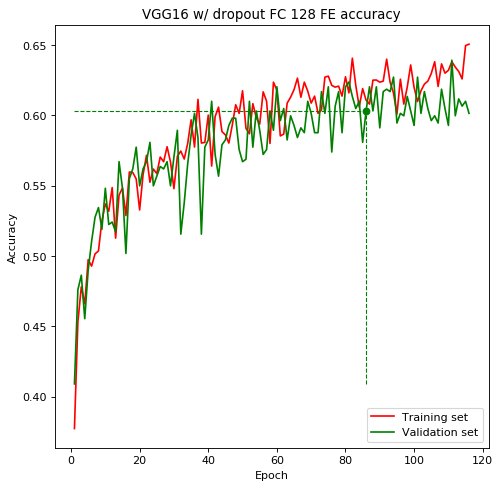

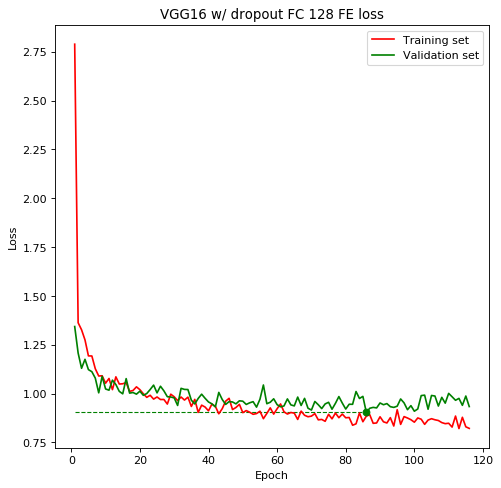

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [47]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256, output=2)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
 1/19 [>.............................] - ETA: 28sWARNING:tensorflow:Can save best model only with val_loss available, skipping.


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[128,2] labels_size=[128,4]
	 [[node loss/dense_14_loss/softmax_cross_entropy_with_logits (defined at <ipython-input-48-72678e9923fa>:9) ]] [Op:__inference_distributed_function_17311]

Function call stack:
distributed_function


In [ ]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [34]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
_________________________________

In [14]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 36,046,722
Non-trainable params: 12,354,880
_________________________________

In [15]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [16]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 0.8684 - accuracy: 0.5840
Epoch 00001: val_loss improved from inf to 0.61834, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [==============================] - 17s 3s/step - loss: 0.8231 - accuracy: 0.5940 - val_loss: 0.6183 - val_accuracy: 0.5543
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6268 - accuracy: 0.6543
Epoch 00002: val_loss did not improve from 0.61834
5/5 [==============================] - 9s 2s/step - loss: 0.6043 - accuracy: 0.6577 - val_loss: 0.6724 - val_accuracy: 0.6014
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6200 - accuracy: 0.6731
Epoch 00003: val_loss improved from 0.61834 to 0.55831, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - lo

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5599 - accuracy: 0.7188
Epoch 00029: val_loss did not improve from 0.55662
5/5 [==============================] - 11s 2s/step - loss: 0.5539 - accuracy: 0.7250 - val_loss: 0.5603 - val_accuracy: 0.6486
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5386 - accuracy: 0.7350
Epoch 00030: val_loss improved from 0.55662 to 0.53693, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5441 - accuracy: 0.7349 - val_loss: 0.5369 - val_accuracy: 0.6775
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5485 - accuracy: 0.7480
Epoch 00031: val_loss did not improve from 0.53693
5/5 [==============================] - 10s 2s/step - loss: 0.5380 - accuracy: 0.7609 - val_loss: 0.5576 - val_accuracy: 0.6993
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5322 - accuracy: 0.7461
Epoch 00032: val_loss did not improve fro

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5251 - accuracy: 0.7637
Epoch 00059: val_loss did not improve from 0.47424
5/5 [==============================] - 11s 2s/step - loss: 0.5127 - accuracy: 0.7547 - val_loss: 0.5406 - val_accuracy: 0.7029
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5440 - accuracy: 0.7286
Epoch 00060: val_loss did not improve from 0.47424
5/5 [==============================] - 11s 2s/step - loss: 0.5414 - accuracy: 0.7299 - val_loss: 0.5515 - val_accuracy: 0.6739
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4884 - accuracy: 0.7734
Epoch 00061: val_loss did not improve from 0.47424
5/5 [==============================] - 10s 2s/step - loss: 0.5089 - accuracy: 0.7641 - val_loss: 0.5617 - val_accuracy: 0.6522
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5077 - accuracy: 0.7715
Epoch 00062: val_loss did not improve from 0.47424
5/5 [==============================] - 

In [17]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [18]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 81
Epoch [opt]: 51
Valid accuracy [end]: 0.6594
Valid accuracy [opt]: 0.7246
Test accuracy [end]:  0.7564
Test accuracy [opt]:  0.7532
Valid loss [end]: 0.6290
Valid loss [opt]: 0.4742
Test loss [end]:  0.5604
Test loss [opt]:  0.5177


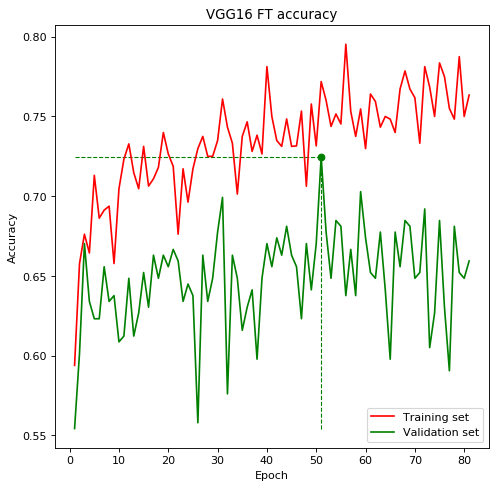

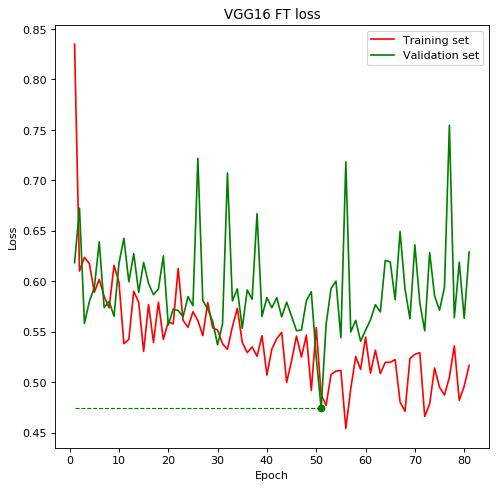

In [19]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [20]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 38,406,530
Non-trainable params: 9,995,072
__________________________________

In [21]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [22]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4859 - accuracy: 0.7628
Epoch 00001: val_loss improved from inf to 0.55881, saving model to vgg16_ft_2layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.4935 - accuracy: 0.7601 - val_loss: 0.5588 - val_accuracy: 0.6920
Epoch 2/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5241 - accuracy: 0.7393
Epoch 00002: val_loss did not improve from 0.55881
5/5 [==============================] - 10s 2s/step - loss: 0.5122 - accuracy: 0.7466 - val_loss: 0.5708 - val_accuracy: 0.6667
Epoch 3/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4547 - accuracy: 0.7812
Epoch 00003: val_loss did not improve from 0.55881
5/5 [==============================] - 10s 2s/step - loss: 0.4590 - accuracy: 0.7785 - val_loss: 0.5858 - val_accuracy: 0.6812
Epoch 4/200
4/5 [=======================>......] - E

Epoch 59/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5249 - accuracy: 0.7637
Epoch 00059: val_loss did not improve from 0.50515
5/5 [==============================] - 10s 2s/step - loss: 0.5058 - accuracy: 0.7685 - val_loss: 0.5778 - val_accuracy: 0.6304
Epoch 60/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4885 - accuracy: 0.7778
Epoch 00060: val_loss did not improve from 0.50515
5/5 [==============================] - 10s 2s/step - loss: 0.4955 - accuracy: 0.7735 - val_loss: 0.6013 - val_accuracy: 0.6630
Epoch 61/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5132 - accuracy: 0.7520
Epoch 00061: val_loss did not improve from 0.50515
5/5 [==============================] - 10s 2s/step - loss: 0.5103 - accuracy: 0.7563 - val_loss: 0.5334 - val_accuracy: 0.6486
Epoch 62/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4751 - accuracy: 0.7863
Epoch 00062: val_loss did not improve from 0.50515
5/5 [==============================] - 

In [23]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [24]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 70
Epoch [opt]: 40
Valid accuracy [end]: 0.6920
Valid accuracy [opt]: 0.6775
Test accuracy [end]:  0.7692
Test accuracy [opt]:  0.7917
Valid loss [end]: 0.5626
Valid loss [opt]: 0.5052
Test loss [end]:  0.5193
Test loss [opt]:  0.5144


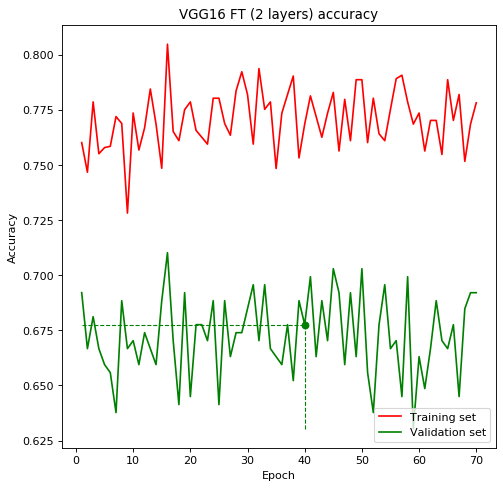

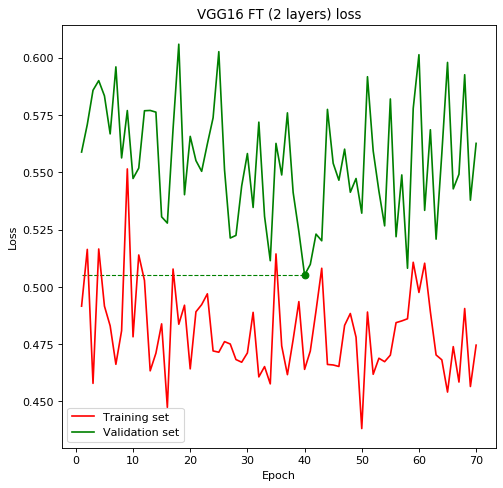

In [25]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [26]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 40,766,338
Non-trainable params: 7,635,264
__________________________________

In [27]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [28]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5445 - accuracy: 0.7305
Epoch 00001: val_loss improved from inf to 0.55831, saving model to vgg16_ft_3layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5342 - accuracy: 0.7359 - val_loss: 0.5583 - val_accuracy: 0.6667
Epoch 2/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4678 - accuracy: 0.7637
Epoch 00002: val_loss improved from 0.55831 to 0.54674, saving model to vgg16_ft_3layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.4503 - accuracy: 0.7701 - val_loss: 0.5467 - val_accuracy: 0.6812
Epoch 3/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4718 - accuracy: 0.7617
Epoch 00003: val_loss improved from 0.54674 to 0.53390, saving model to vgg16_ft_3layer_4cl_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.4934 - accuracy: 0.7

Epoch 30/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4478 - accuracy: 0.7927
Epoch 00030: val_loss did not improve from 0.50082
5/5 [==============================] - 11s 2s/step - loss: 0.4495 - accuracy: 0.7936 - val_loss: 0.5829 - val_accuracy: 0.6522
Epoch 31/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4540 - accuracy: 0.7949
Epoch 00031: val_loss did not improve from 0.50082
5/5 [==============================] - 10s 2s/step - loss: 0.4460 - accuracy: 0.8020 - val_loss: 0.5328 - val_accuracy: 0.6957
Epoch 32/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4790 - accuracy: 0.7637
Epoch 00032: val_loss did not improve from 0.50082
5/5 [==============================] - 10s 2s/step - loss: 0.4748 - accuracy: 0.7594 - val_loss: 0.5132 - val_accuracy: 0.6848
Epoch 33/200
4/5 [=======================>......] - ETA: 1s - loss: 0.4710 - accuracy: 0.7793
Epoch 00033: val_loss did not improve from 0.50082
5/5 [==============================] - 

In [29]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [30]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 46
Epoch [opt]: 16
Valid accuracy [end]: 0.6848
Valid accuracy [opt]: 0.6993
Test accuracy [end]:  0.7885
Test accuracy [opt]:  0.7885
Valid loss [end]: 0.5404
Valid loss [opt]: 0.5008
Test loss [end]:  0.5090
Test loss [opt]:  0.5149


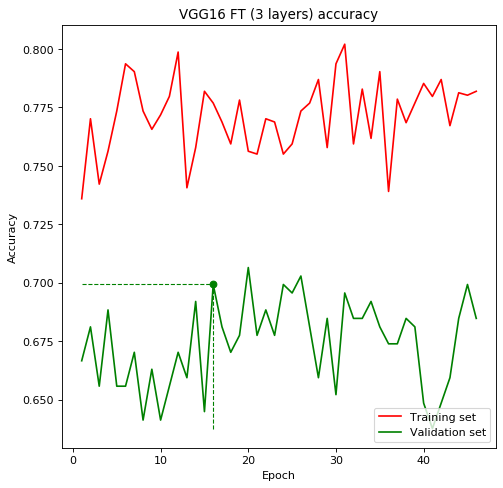

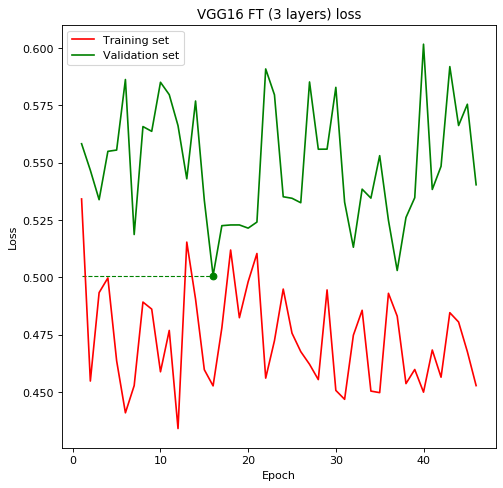

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();